# Data to use

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
amz_data = ["Appliances_5", "Software_5", "Prime_Pantry_5", "Industrial_and_Scientific_5", "Musical_Instruments_5"]

In [2]:
for data in amz_data:
    !eval {"wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/{filename}.json.gz".format(filename=data)}

--2021-08-12 13:21:06--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Appliances_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72998 (71K) [application/octet-stream]
Saving to: ‘Appliances_5.json.gz’

Appliances_5.json.g 100%[===================>]  71.29K   118KB/s    in 0.6s    

2021-08-12 13:21:07 (118 KB/s) - ‘Appliances_5.json.gz’ saved [72998/72998]

--2021-08-12 13:21:07--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz’

Software_5.json.gz  100%[===================>]   5.09M   959KB/s    in 5.4s    

# Download data

# Import libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import gzip
import json
import nltk
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

In [9]:
tf.config.list_physical_devices('GPU')

2021-08-12 13:29:38.512536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-12 13:29:38.513425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 3080 computeCapability: 8.6
coreClock: 1.71GHz coreCount: 68 deviceMemorySize: 9.78GiB deviceMemoryBandwidth: 707.88GiB/s
2021-08-12 13:29:38.513572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-12 13:29:38.514201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-12 13:29:38.514733: I tensorflow/core/common

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Make Data Frame from JSON

In [7]:
def getJSON(path):
  zip_extracts = gzip.open(path, 'rb')
  for json_file in zip_extracts:
    yield json.loads(json_file)

def getDF(path):
  key = 0
  DF_dict = {}
  for data in getJSON(path):
    DF_dict[key] = data
    key += 1
  return pd.DataFrame.from_dict(DF_dict, orient='index')

In [8]:
all_dfs = []
for i in amz_data:
  temp_df = getDF(i + ".json.gz")
  category = [i] * temp_df.shape[0]
  temp_df['category'] = category
  all_dfs.append(temp_df)

all_rv_DF = pd.concat(all_dfs)
all_rv_DF.dropna(subset=['reviewText'],inplace=True)
print(len(all_rv_DF))
del(all_dfs)

461096


# Separate positive reviews and negative reviews

In [9]:
positive_DF = all_rv_DF[all_rv_DF['overall']>3].copy()
negative_DF = all_rv_DF[all_rv_DF['overall']<3].copy()
del(all_rv_DF)

In [10]:
print(len(positive_DF),len(negative_DF))

401188 28312


# Taking 20000 positive and 20000 negative samples

In [11]:
positive_samples = positive_DF.sample(n=20000,replace=False)
negative_samples = negative_DF.sample(n=20000,replace=False)

all_data = pd.concat([positive_samples,negative_samples]).copy()

del(positive_samples)
del(negative_samples)

# Data Preprocessing

In [12]:
data = all_data

sentiments = []
for x in data['overall']:
  if (x>3):
    sentiments.append(1)
  if (x<3):
    sentiments.append(-1)
  
data['sentiment'] = sentiments
data['reviewText'] = data['reviewText'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

all_text = []
for rv_text in data['reviewText']:
  all_text.extend(rv_text.split(' '))

num_words = int(len(set(all_text)) * (3/4))
print(num_words)

data_train = []
data_test = {}

for cat in amz_data:
  temp_df = data[data['category'] == cat]
  temp_train, temp_test = train_test_split(temp_df, test_size = 0.25, random_state = 10)
  data_train.append(temp_train)
  data_test[cat] = temp_test

data_train = pd.concat(data_train)
data_train.sample(frac=1)

tokenizer = Tokenizer(num_words=num_words, lower=True,split=' ')
tokenizer.fit_on_texts(data['reviewText'].values)

max_sq_len = 0

X_train = tokenizer.texts_to_sequences(data_train['reviewText'].values)
Y_train = pd.get_dummies(data_train['sentiment']).values

max_sq_len = len(max(X_train, key=len))
print(max_sq_len)

X_test_cat = {}
Y_test_cat = {}
for cat in amz_data:
  X_test_cat[cat] = tokenizer.texts_to_sequences(data_test[cat]['reviewText'].values)
  Y_test_cat[cat] = pd.get_dummies(data_test[cat]['sentiment']).values

X_train = pad_sequences(X_train, max_sq_len)
for cat in amz_data:
  X_test_cat[cat] = pad_sequences(X_test_cat[cat], max_sq_len)

X_test = []
Y_test = []
for cat in amz_data:
  X_test.extend(X_test_cat[cat])
  Y_test.extend(Y_test_cat[cat])

X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

58347
3393
(29997, 3393) (29997, 2)
(10003, 3393) (10003, 2)


# Making the model

In [13]:
embed_dim = 512
lstm_out = 512
batch_size = 50

model = Sequential()
model.add(Embedding(num_words, embed_dim,input_length = X_train.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3393, 512)         29873664  
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 32,120,770
Trainable params: 32,120,770
Non-trainable params: 0
____________________________________________

In [14]:
filepath = "model.h5"

# Training

In [15]:
# define the checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [16]:
# fit the model
model.fit(X_train, Y_train, batch_size = batch_size, epochs = 10, verbose = 1, validation_data=(X_test, Y_test), callbacks=callbacks_list)

Epoch 1/10
600/600 [==============================] - 793s 1s/step - loss: 0.4844 - accuracy: 0.7666 - val_loss: 0.3058 - val_accuracy: 0.8771

Epoch 00001: val_loss improved from inf to 0.30576, saving model to /content/drive/MyDrive/University Tasks/RNN_assignment/model.h5
Epoch 2/10
600/600 [==============================] - 776s 1s/step - loss: 0.2279 - accuracy: 0.9165 - val_loss: 0.2987 - val_accuracy: 0.8821

Epoch 00002: val_loss improved from 0.30576 to 0.29871, saving model to /content/drive/MyDrive/University Tasks/RNN_assignment/model.h5
Epoch 3/10
600/600 [==============================] - 775s 1s/step - loss: 0.1295 - accuracy: 0.9547 - val_loss: 0.3167 - val_accuracy: 0.8858

Epoch 00003: val_loss did not improve from 0.29871
Epoch 4/10
600/600 [==============================] - 773s 1s/step - loss: 0.0860 - accuracy: 0.9708 - val_loss: 0.3921 - val_accuracy: 0.8796

Epoch 00004: val_loss did not improve from 0.29871
Epoch 5/10
600/600 [==============================] - 

# Testing

## Overall accuracy

In [17]:
model = load_model(filepath)

In [18]:
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Test Accuracy: %.2f" % (acc))

201/201 [==============================] - 75s 371ms/step - loss: 0.2987 - accuracy: 0.8821
Score: 0.30
Test Accuracy: 0.88


## Individual category accuracy

In [19]:
for cat in amz_data:
  score,acc = model.evaluate(X_test_cat[cat], Y_test_cat[cat], verbose = 1, batch_size = batch_size)
  print(cat, "Score: %.2f" % (score))
  print(cat, "Test Accuracy: %.2f" % (acc))

1/1 [==============================] - 0s 230ms/step - loss: 0.1208 - accuracy: 0.9630
Appliances_5 Score: 0.12
Appliances_5 Test Accuracy: 0.96
11/11 [==============================] - 4s 342ms/step - loss: 0.3012 - accuracy: 0.8765
Software_5 Score: 0.30
Software_5 Test Accuracy: 0.88
56/56 [==============================] - 20s 365ms/step - loss: 0.2697 - accuracy: 0.8958
Prime_Pantry_5 Score: 0.27
Prime_Pantry_5 Test Accuracy: 0.90
33/33 [==============================] - 12s 369ms/step - loss: 0.2975 - accuracy: 0.8880
Industrial_and_Scientific_5 Score: 0.30
Industrial_and_Scientific_5 Test Accuracy: 0.89
102/102 [==============================] - 38s 374ms/step - loss: 0.3155 - accuracy: 0.8730
Musical_Instruments_5 Score: 0.32
Musical_Instruments_5 Test Accuracy: 0.87


## Confusion Matrix

In [20]:
predictions = model.predict(X_test)
Y_pred = (predictions > 0.5)

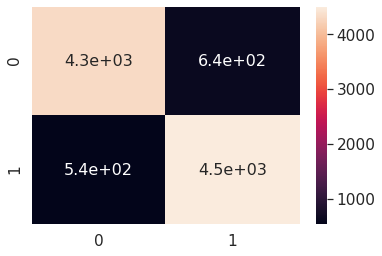

In [21]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, range(2), range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()